## Perceptual decision making

### 1. Data generation
$u(t)= \bigg\{ \begin{array}{ll} \bar{u} + \xi (t) & \text{if } 5 \leq t \leq 45 \\  \xi (t) & otherwise \end{array}$

$\bar{u}$ stimulus strength, drawn from a uniformormly from $\pm \frac{3.2}{100} \{1,2,4,8,16\}$ 

$\xi (t)$ is background noise, drawn from a normal distribution with mean 0 and standard deviation 0.03. 

resample for each trial. noise resampled for each time step. 

target $y$ is $sgn(\bar{u})$

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# #%matplotlib inline

In [28]:
# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [147]:
class DecisionDataset(Dataset):
    def __init__(self, n_trials, n_time_step=75):   
        """
        Generate perceptual decision-making data.

        Parameters
        ----------
        n_trials : int
            Number of trials.
        n_time_step : int (Default: 75)
            Number of time steps.
        Returns
        -------
        u : array, shape (n_trials,n_time_step)
            input 
        y : array, shape (n_trials,n_time_step)
            output 
        """
        strength_choices = (3.2/ 100)  * np.array([1,2,4,8,16, -1,-2,-4,-8,-16])
        n_time_step = 75
        time_step= 20 #ms

        u = np.zeros([n_trials,n_time_step])
        y = np.zeros([n_trials,n_time_step])

        for trial in range(n_trials):
            strength = np.random.choice(strength_choices)

            for t in range(0,n_time_step):
                if t>=5 and t<=45:
                    #noise with std 0.03
                    u[trial,t] = strength + np.random.normal(0,0.03)
                else:
                    u[trial, t] = np.random.normal(0,0.03)

                y[trial, t] = np.sign(strength)
        
        self.u = torch.tensor(u, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.n_trials = n_trials
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, idx):
        return self.u[idx,:], self.y[idx,:]

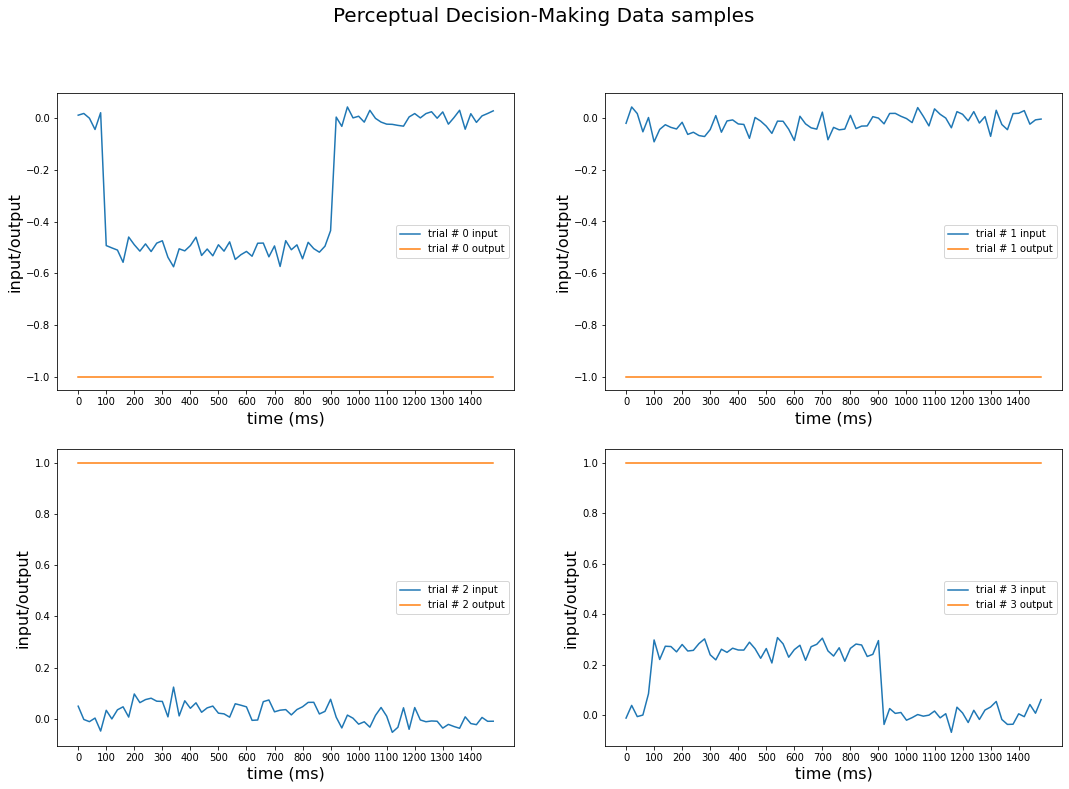

In [148]:
d_data = DecisionDataset(1000)
d_dataloader = DataLoader(d_data, batch_size=32)

u_arr, y_arr = next(iter(d_dataloader))

plt.figure(figsize=(18,12))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()

### 2. Recurrent neural network
one dimensional input and output, 

N units in the hidden layer, 

left and right connectivity vector $m, n$ trainable parameters, 

fixed input and output weights $I, W$. 

trainable and fixed weights are drawn from standard normal distribution. 

$\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t)$ 

$\phi(x) = \tanh$ 

$\tau = 100 ms$ 
 
$\Delta t = 20 ms$ 

$J = \frac{1}{N} mn^T$ 

Using forward Euler method to solve the differential equation. 

$x_i(t+ \Delta t) = x_i(t) + \frac{1}{\tau}  \Delta t  \bigg( -x_i(t) + \sum_{j=1}^N J_{ij} \phi(x_j(t)) + I_i u(t) \bigg)$ 



In [191]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,N):
        super(RNN, self).__init__()

        self.hidden_size = N

        # Weight initialization
        # TODO: Replace J with m and n where J is the outer product of m and n
        self.J = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size)) # Hidden to hidden weight
        self.I = torch.randn(1, self.hidden_size)  # input to hidden weight
        self.w = torch.randn(self.hidden_size, 1)  # hidden to output weight

        # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()

    def forward(self, u):
        x = torch.randn(1, self.hidden_size)  # Initial hidden state
        z= torch.zeros(u.shape) # Output 
        
#         print("u shape: ", u.shape)
#         print("x shape: ", x.shape)
        
        for i in range(u.size(1)):
            # Weight update formula
            
            j_sum = torch.matmul(self.activation(x), self.J)
            Iu = torch.matmul(u[:,i].unsqueeze(1), self.I)
            
#             print("j sum shape: ", j_sum.shape)
#             print("iu shape: ", Iu.shape)
            
            delta_x = (
                -x
                # TODO: Adjust code to work with m and n
                + j_sum
                + Iu
            ) * (self.dt / self.tau)
            
            # print("delta_x shape: ", delta_x.shape)
            
            x = x + delta_x

            # print("x shape: ", x.shape)
            # print("w shape: ", self.w.shape)
            output = torch.matmul(self.activation(x), self.w)
            output = 1/self.hidden_size * output
            # print("out shape: ", output.shape)
            # print("z shape: ", z.shape)
            # print("z[:, i] shape: ", z[:, i].shape)
            z[:, i] = output.flatten()
        return z

In [198]:
import torch
import torch.nn

class RNN(nn.Module):
    
    def __init__(self, network_size=128):
        
        super(RNN, self).__init__()
        self.network_size = network_size
        
        # Weight initialization
        # TODO: This eventually needs to be changed to n and m
        self.m = nn.Parameter(torch.rand(self.network_size))
        self.n = nn.Parameter(torch.rand(self.network_size))
        #self.J = nn.Parameter(torch.randn(self.network_size, self.network_size))
        self.I = torch.randn(self.network_size)
        self.w = torch.randn(self.network_size)
        
                # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()
        
        with torch.no_grad():
            self.m.normal_(std=1)
            self.n.normal_(std=1)
            #self.J.normal_(std=1)
            #self.I.normal_()
            #self.w.normal_()
            
        # print(self.J)
        
    def forward(self, u):
        
#         print("u shape: ", u.shape)
        
        x = torch.randn(u.size(0), self.network_size)
        z = torch.zeros(u.shape)
        
        J = torch.matmul(self.m[:,None], self.n[None,:]) / self.network_size
        
        for i in range(u.size(1)):
            
#             print("x shape: ", x.shape)
#             print("J shape: ", self.J.shape)
#             J_sum = torch.matmul(self.activation(x), self.J)
#             print("J_sum shape: ", J_sum.shape)
#             print("I shape: ", self.I.shape)
#             print("u[:,i] shape: ", u[:,i].shape)
#             Iu = torch.matmul(u[:,i,None], self.I[None,:])
#             print("Iu shape: ", Iu.shape)
            
            delta_x = (
                -x 
                + torch.matmul(self.activation(x), J) 
                + torch.matmul(u[:,i,None], self.I[None,:])
            ) * (self.dt / self.tau)
            
            x = x + delta_x
            
            output = torch.matmul(self.activation(x), self.w) / self.network_size            
            z[:, i] = output    
            
        return z
            
        

In [197]:
u_test, y_test = data(3)
u_test = torch.tensor(u_test, dtype=torch.float32)


model_test = RNN(128)
model_test.forward(u_test)

AttributeError: 'RNN' object has no attribute 'J'

### 3. Training
train a network of size $N=128$. batch size 32 trals. and specific lost function is defined as the mean squared error of last $T=15$ time step of each trial:

$loss = \frac{1}{32 * 15} \sum_{i=1}^{32} \sum_{t=45}^{60} (z_i(t) - y_i(t))^2$ 

learning rate $0.05$ , Adam optimizer.

In [153]:
# TODO: Rewrite to remove two for loops

n_epochs = 1000

mini_batch_size = 32

learning_rate = 5e-3

T=15

model = RNN(N=128)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

u, y = data(n_trials=1000)

for epoch in range(n_epochs):
    for trial in range(u.shape[0]):
        
        input = torch.tensor(u[trial,:], dtype=torch.float32)
        target = torch.tensor(y[trial,:], dtype=torch.float32)

        optimizer.zero_grad()

        output = model(input.unsqueeze(1))

        loss = loss_fn(output[-T:], target[-T:])

        loss.backward()

        optimizer.step()

        if epoch % 100 == 0:
            print("Epoch %d, Loss %f" % (epoch, float(loss)))

TypeError: __init__() got an unexpected keyword argument 'N'

In [202]:
# Training function slightly modified from PyTorch quickstart tutorial
def train(dataloader, model, loss_fn, optimizer, T=15):
    size = len(dataloader.dataset)
    optimizer.zero_grad()
    model.train(True)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print("pred shape: ", pred.shape)
        loss = loss_fn(pred[:,-T:], y[:,-T:])

        # print(pred[0, :])
        # print(pred[0, -T:])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [200]:
# Overfitting sanity check
d_dataset = DecisionDataset(32)
train_dataloader = DataLoader(d_dataset, batch_size=32)

n_epochs = 1000
learning_rate = 5e-3
T=15
model = RNN(128)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(1000):
    train(train_dataloader, model, loss_fn, optimizer, T=T)

loss: 1.000423  [   32/   32]
loss: 1.000417  [   32/   32]
loss: 1.000412  [   32/   32]
loss: 1.000408  [   32/   32]
loss: 1.000404  [   32/   32]
loss: 1.000401  [   32/   32]
loss: 1.000398  [   32/   32]
loss: 1.000396  [   32/   32]
loss: 1.000393  [   32/   32]
loss: 1.000391  [   32/   32]
loss: 1.000389  [   32/   32]
loss: 1.000386  [   32/   32]
loss: 1.000383  [   32/   32]
loss: 1.000379  [   32/   32]
loss: 1.000375  [   32/   32]
loss: 1.000371  [   32/   32]
loss: 1.000366  [   32/   32]
loss: 1.000360  [   32/   32]
loss: 1.000354  [   32/   32]
loss: 1.000347  [   32/   32]
loss: 1.000340  [   32/   32]
loss: 1.000331  [   32/   32]
loss: 1.000322  [   32/   32]
loss: 1.000313  [   32/   32]
loss: 1.000302  [   32/   32]
loss: 1.000291  [   32/   32]
loss: 1.000278  [   32/   32]
loss: 1.000265  [   32/   32]
loss: 1.000251  [   32/   32]
loss: 1.000235  [   32/   32]
loss: 1.000219  [   32/   32]
loss: 1.000202  [   32/   32]
loss: 1.000183  [   32/   32]
loss: 1.00

loss: 0.482746  [   32/   32]
loss: 0.467114  [   32/   32]
loss: 0.522877  [   32/   32]
loss: 0.497101  [   32/   32]
loss: 0.450849  [   32/   32]
loss: 0.474954  [   32/   32]
loss: 0.539773  [   32/   32]
loss: 0.513741  [   32/   32]
loss: 0.534154  [   32/   32]
loss: 0.494290  [   32/   32]
loss: 0.445407  [   32/   32]
loss: 0.542414  [   32/   32]
loss: 0.454400  [   32/   32]
loss: 0.467982  [   32/   32]
loss: 0.463137  [   32/   32]
loss: 0.482679  [   32/   32]
loss: 0.469857  [   32/   32]
loss: 0.483752  [   32/   32]
loss: 0.471343  [   32/   32]
loss: 0.471934  [   32/   32]
loss: 0.496980  [   32/   32]
loss: 0.502953  [   32/   32]
loss: 0.454491  [   32/   32]
loss: 0.459438  [   32/   32]
loss: 0.462424  [   32/   32]
loss: 0.482447  [   32/   32]
loss: 0.548455  [   32/   32]
loss: 0.464811  [   32/   32]
loss: 0.525691  [   32/   32]
loss: 0.432468  [   32/   32]
loss: 0.481197  [   32/   32]
loss: 0.437155  [   32/   32]
loss: 0.473262  [   32/   32]
loss: 0.41

loss: 0.304848  [   32/   32]
loss: 0.299318  [   32/   32]
loss: 0.344347  [   32/   32]
loss: 0.340407  [   32/   32]
loss: 0.358553  [   32/   32]
loss: 0.339984  [   32/   32]
loss: 0.393965  [   32/   32]
loss: 0.344990  [   32/   32]
loss: 0.341157  [   32/   32]
loss: 0.331048  [   32/   32]
loss: 0.379109  [   32/   32]
loss: 0.342357  [   32/   32]
loss: 0.352580  [   32/   32]
loss: 0.358657  [   32/   32]
loss: 0.338419  [   32/   32]
loss: 0.324330  [   32/   32]
loss: 0.300087  [   32/   32]
loss: 0.340319  [   32/   32]
loss: 0.314753  [   32/   32]
loss: 0.329846  [   32/   32]
loss: 0.319812  [   32/   32]
loss: 0.369450  [   32/   32]
loss: 0.336414  [   32/   32]
loss: 0.302516  [   32/   32]
loss: 0.310161  [   32/   32]
loss: 0.300439  [   32/   32]
loss: 0.308416  [   32/   32]
loss: 0.347958  [   32/   32]
loss: 0.294039  [   32/   32]
loss: 0.300690  [   32/   32]
loss: 0.314421  [   32/   32]
loss: 0.315713  [   32/   32]
loss: 0.344350  [   32/   32]
loss: 0.33

loss: 0.244928  [   32/   32]
loss: 0.247633  [   32/   32]
loss: 0.287835  [   32/   32]
loss: 0.276356  [   32/   32]
loss: 0.256346  [   32/   32]
loss: 0.266530  [   32/   32]
loss: 0.308196  [   32/   32]
loss: 0.267573  [   32/   32]
loss: 0.258425  [   32/   32]
loss: 0.250934  [   32/   32]
loss: 0.249966  [   32/   32]
loss: 0.244488  [   32/   32]
loss: 0.292054  [   32/   32]
loss: 0.280621  [   32/   32]
loss: 0.250665  [   32/   32]
loss: 0.243846  [   32/   32]
loss: 0.321919  [   32/   32]
loss: 0.297721  [   32/   32]
loss: 0.294960  [   32/   32]
loss: 0.282752  [   32/   32]
loss: 0.258342  [   32/   32]
loss: 0.249519  [   32/   32]
loss: 0.255903  [   32/   32]
loss: 0.264460  [   32/   32]
loss: 0.259724  [   32/   32]
loss: 0.285632  [   32/   32]
loss: 0.265778  [   32/   32]
loss: 0.250965  [   32/   32]
loss: 0.238598  [   32/   32]
loss: 0.254760  [   32/   32]
loss: 0.257147  [   32/   32]
loss: 0.248938  [   32/   32]
loss: 0.276121  [   32/   32]
loss: 0.23

In [204]:
d_dataset = DecisionDataset(32000)
train_dataloader = DataLoader(d_dataset, batch_size=32)

n_epochs = 1000
learning_rate = 5e-3
T=15
model = RNN(128)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(train_dataloader, model, loss_fn, optimizer, T=T)

loss: 0.999873  [   32/32000]
loss: 0.844243  [ 3232/32000]
loss: 0.419002  [ 6432/32000]
loss: 0.398008  [ 9632/32000]
loss: 0.357572  [12832/32000]
loss: 0.218009  [16032/32000]
loss: 0.196138  [19232/32000]
loss: 0.258751  [22432/32000]
loss: 0.178576  [25632/32000]
loss: 0.167995  [28832/32000]
